In [43]:
import sys

from os.path import dirname, abspath
import os
sys.path.append(dirname(abspath(os.getcwd())))
import gymnasium as gym
import torch
import gym_usv
import numpy as np
from cleanrl.rpo_continuous_action import Agent, make_env
import matplotlib.pyplot as plt
from IPython.display import Video
import tempfile
from tqdm import tqdm
import pandas as pd

import seaborn as sns
sns.set_theme(style="whitegrid")

In [2]:
# Make environment
envs = gym.vector.SyncVectorEnv(
        [make_env("usv-asmc-ca-v0", 0, False, "test_run", 0.99) for i in range(1)]
    )

/Users/abiel/mambaforge/envs/sb3/lib/python3.10/site-packages/gymnasium/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [3]:
agent = Agent(envs, 0.5)
agent_dict = torch.load('agent.pt')
agent.load_state_dict(agent_dict, strict=False)
agent.eval()

envs.envs[0].obs_rms.mean = agent_dict['obs_rms_mean']
envs.envs[0].obs_rms.var = agent_dict['obs_rms_var']

agent

Agent(
  (critic): Sequential(
    (0): Linear(in_features=12, out_features=200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=200, out_features=300, bias=True)
    (5): Tanh()
    (6): Linear(in_features=300, out_features=1, bias=True)
  )
  (actor_mean): Sequential(
    (0): Linear(in_features=12, out_features=200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=200, out_features=300, bias=True)
    (5): Tanh()
    (6): Linear(in_features=300, out_features=2, bias=True)
  )
)

In [4]:
options = {'row_n': 10, 'col_n': 5, 'renderplots': False}

next_obs, _ = envs.reset(options=options)
next_obs = torch.Tensor(next_obs)
all_info = []

from gymnasium.wrappers.monitoring import video_recorder
recorder = video_recorder.VideoRecorder(
    envs.envs[0],
    "test_video.mp4"
)

envs.set_attr("render_plots", [False])

for _ in tqdm(range(5000)):
    action, logprob, _, value = agent.get_action_and_value(next_obs)
    next_obs, reward, terminated, truncated, infos = envs.step(action.cpu().numpy())
    all_info.append(infos)
    done = np.logical_or(terminated, truncated)
    if done:
        break
    next_obs = torch.Tensor(next_obs)
    recorder.capture_frame()

recorder.close()
Video("test_video.mp4")

  0%|                                                  | 0/5000 [00:00<?, ?it/s]/Users/abiel/mambaforge/envs/sb3/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:272: UserWarning: WARN: No render modes was declared in the environment (env.metadata['render_modes'] is None or not defined), you may have trouble when calling `.render()`.
  logger.warn(
 20%|███████▊                               | 999/5000 [00:02<00:10, 366.55it/s]


Moviepy - Building video test_video.mp4.
Moviepy - Writing video test_video.mp4



Moviepy - Done !
Moviepy - video ready test_video.mp4


In [46]:
from collections import defaultdict
raw_data = defaultdict(list)
for info in all_info[:-2]:
    keys = all_info[0].keys()
    for key in keys:
        raw_data[key].append(info[key])

data = {}
concat_keys = ['x', 'y', 'reward']
for key in concat_keys:
    data[key] = np.concatenate(raw_data[key])

df = pd.DataFrame.from_dict(data)
df.describe()

,x,y,reward
count,998.000000,998.000000,998.000000
mean,8.747199,3.875810,-5.982977
std,6.149385,6.541450,3.491239
min,-1.292785,-8.260908,-19.467262
25%,2.710379,-1.021547,-6.616178
50%,8.448007,3.859368,-4.948723
75%,14.724835,9.575361,-3.856808
max,18.097534,13.951723,-1.339744


<AxesSubplot:>

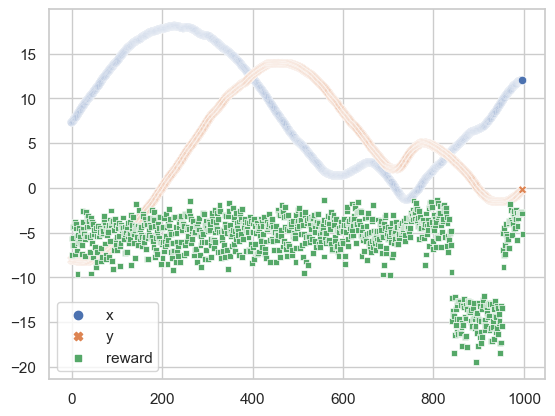

In [49]:
sns.scatterplot(data=df)